# Neural Autoencoders and Dimensionality Reduction

Last time, we studied unsupervised learning through the framework of *autoencoders*. When using autoencoders, the learning problem is to find an *encoder* $\phi_e$ and a *decoder* $\psi_d$ such that a reconstructed data point $\hat{\mathbf{x}} = \psi_d(\phi_e(\mathbf{x}))$ is "close" to the original data point $\mathbf{x}$, where "close" needs to be measured in terms of a loss function. We looked at two examples of autoencoders defined in terms of the square-error loss function: k-means and principal component analysis (PCA). 

PCA in particular is an example of an encoding algorithm for *dimensionality reduction*. The aim of dimensionality reduction is to learn a lower-dimensional representation of the data set in a new feature space that captures its fundamental structure. PCA is the most common form of *linear* dimensionality reduction, in which we aim to learn linear structure that summarizes the data. In these notes we'll focus on neural network methods for *nonlinear* dimensionality reduction, which is sometimes also called *manifold learning*. 

In [34]:
import torch 
import pandas as pd
from sklearn.datasets import make_swiss_roll
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}.")

Running on cpu.


## Learning a Circle

Let's start by attempting to learn a circular structure in noisy circular data: 

[Text(0.5, 0, '$x_1$'), Text(0, 0.5, '$x_2$')]

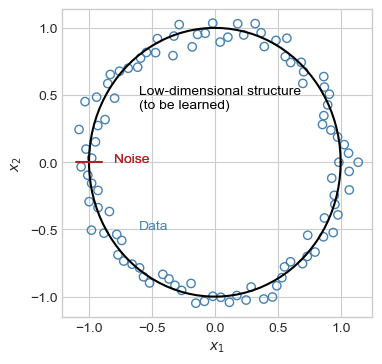

In [168]:
#| code-fold: true
n_points = 100

r = 1
noise = 0.05

theta     = torch.linspace(0, 2*torch.pi, n_points)
r_        = r + torch.randn(n_points)*noise
x1_       = r_*torch.cos(theta) 
x2_       = r_*torch.sin(theta)

x1 = r*torch.cos(theta)
x2 = r*torch.sin(theta)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X = torch.stack([x1_, x2_], dim=1)
ax.scatter(X[:,0], X[:,1], facecolors = "none", edgecolors = "steelblue")
ax.plot(x1, x2, color = "black",  label = "Low-dimensional structure")
ax.plot([-1.1, -0.9], [0, 0], color = "firebrick", label = "Noise")
ax.annotate("Noise", [-0.8, 0], color = "firebrick")
ax.annotate("Low-dimensional structure\n(to be learned)", [-0.6, 0.4], color = "black")
ax.annotate("Noise", [-0.8, 0], color = "firebrick")
ax.annotate("Data", [-0.6, -0.5], color = "steelblue")
ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

This data is approximately circular. A given data point can be *mostly* described by its angle from the center of the circle. 

The following neural network attempts to learn a low-dimensional representation of this data using gradient descent. The encoder is a nonlinear map that sends each data point to a 1D representation. The decoder is a nonlinear map that sends a 1d scalar number to a point in 2D space. Minimizing the reconstruction error corresponds to trying to attempting to learn this low-dimensional structure from the data. 

Note that this model doesn't include any explicit representation of the idea of "circularity": it just tries to learn a low-dimensional representation that minimizes the reconstruction error. 

In [190]:
#---
from torch import nn 
class ManifoldLearner(nn.Module): 
    
    def __init__(self, n_input, n_output, n_hidden=10): 
        super(ManifoldLearner, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.Sigmoid(),
            nn.Linear(n_hidden, n_hidden),
            nn.Sigmoid(), 
            nn.Linear(n_hidden, n_output)
        )
        self.decoder = nn.Sequential(
            nn.Linear(n_output, n_hidden),
            nn.Sigmoid(),
            nn.Linear(n_hidden, n_hidden),
            nn.Sigmoid(),
            nn.Linear(n_hidden, n_input)
        )
        
    def forward(self, x): 
        return self.decoder(self.encoder(x))
#---

Let's try training the model on the example data. We'll use a standard training loop. 

In [191]:
def train(model, X, n_epochs=1000, **kwargs): 
    optimizer = torch.optim.Adam(model.parameters(), **kwargs)
    loss_fn = nn.MSELoss()
    for epoch in range(n_epochs): 
        optimizer.zero_grad()
        X_hat = model(X)
        loss = loss_fn(X_hat, X)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0: 
            print(f"Epoch {epoch}, loss: {loss.item()}")

In [192]:
ml = ManifoldLearner(2, 1, 10)
train(ml, X, 10000, lr = 0.01)

Epoch 0, loss: 0.5466600656509399
Epoch 1000, loss: 0.011602207086980343
Epoch 2000, loss: 0.0031473031267523766
Epoch 3000, loss: 0.002627552952617407
Epoch 4000, loss: 0.002384128514677286
Epoch 5000, loss: 0.0037290481850504875
Epoch 6000, loss: 0.002180744195356965
Epoch 7000, loss: 0.002122132107615471
Epoch 8000, loss: 0.0020773224532604218
Epoch 9000, loss: 0.0021929796785116196


Now let's take a look at the learned data representation. First, we'll generate some evenly-spaced "codes." Then, we'll decode these codes in order to see how they map into the original data space. 

In [384]:
x = torch.linspace(5*X.min(), 5*X.max(), 10001)[:, None]
x.size()

torch.Size([10001, 1])

In [385]:
#---
approx = ml.decoder(x) # "decoded" data
approx.size()
#---

torch.Size([10001, 2])

We see that the decoder has mapped 1D codes into 2D data points. Such a mapping, if continuous, describes a curve in 2D space. Let's take a look! 

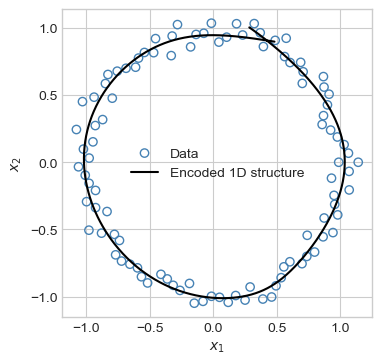

In [386]:
#| code-fold: true
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.scatter(X[:,0], X[:,1], facecolors = "none", edgecolors = "steelblue", label = "Data")
ax.plot(approx.detach()[:,0], approx.detach()[:,1], color = "black", label = "Encoded 1D structure")
ax.legend()
labs = ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

We can see that the encoder approximated the circular structure of the data relatively well for most of the data domain, with only a gap in a small part of the learned curve. As we might expect, the learned curve is not a perfect circle due to the noisiness of the data and the limited flexibility of our model.  

## Example 2: Image Embedding

[*Major components of the code in this section are adapted from ["Variational Autoencoder: PyTorch Tutorial"](https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f) by Reza Kalantar.*]{.aside} 

Let's consider the problem of embedding images in a low-dimensional space. Our aim is to learn a low-dimensional representation of a complex image data set that represents similarities between the images in some way. 

Image embedding via autoencoders was a state-of-the-art technique for image generation before the advent of diffusion methods. 

To illustrate the task of image embedding, we will finally use a very famous data set. MNIST is a data set containing 28x28 grayscale images of handwritten digits. The data set was originally collected by the National Institute of Standards and Technology (NIST) to motivate research into the automated recognition of handwritten digits; the initial motivation for this task was to automate the process of reading zip codes on snail mail.

In [333]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
s = torch.manual_seed(123)

In [382]:
# download a copy of the MNIST training data set
path = '~/datasets'
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(path, transform=transform, download=True)

# create a data loader
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


Here's an excerpt of the data from the training data loader. 

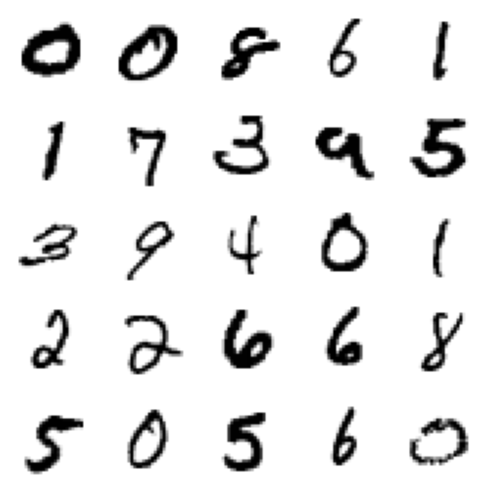

In [380]:
# get 25 sample training images for visualization
image = next(iter(train_loader))[0]

fig, ax = plt.subplots(5, 5, figsize=(5, 5))

for ax, im in zip(ax.ravel(), image):
    ax.imshow(im[0], cmap='gray_r')
    ax.axis('off')
plt.tight_layout()

The data also comes with true labels for the digits, which we will ignore for our purposes today. 

This data excerpt places the images somewhat randomly. Can we find a low-dimensional representation of the data that would, for example, place the 0s together, the 9s together, etc? Maybe this representation would even place 3s near 8s and 9s near 4s, since these digits are orthographically somewhat similar. 

Our aim is to learn an underlying low-dimensional structure to this data using a neural autoencoder. Here is the neural network we'll use. This autoencoder is somewhat more complex than the other encoders we've studied, but it operates on the same principle: use an encoder to learn a low-dimensional code, alongside a decoder which reconstructs approximate original data points from the low-dimensional code. 

In [383]:
#---
class AutoEncoder(nn.Module):

    def __init__(self, input_dim=784, device=device):
        super(AutoEncoder, self).__init__()

        # encoder: just a simple stack of linear layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            )
        
        # decoder: the same stack, in the other direction. 
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))
#---

For data that has a natural minimum and maximum value, it is often more appropriate to use a cross-entropy loss function than a square-error loss function. 

In [337]:
def loss_function(x, x_hat):
    return nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

Now we can define a standard training loop: 

In [338]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            # print(x.size())
            x = x.to(device)
            x = x.flatten(start_dim=1).to(device)

            optimizer.zero_grad()

            x_hat = model(x)
            loss = loss_function(x, x_hat)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))

Next we need to instantiate a model and optimizer: 

In [339]:
AE = AutoEncoder().to(device)
optimizer = torch.optim.Adam(AE.parameters(), lr=1e-3)

And now it's training time! 

In [340]:
train(AE, optimizer, epochs=20, device=device)

	Epoch 1 	Average Loss:  196.66621066034537
	Epoch 2 	Average Loss:  164.1012509618896
	Epoch 3 	Average Loss:  156.26172655923935
	Epoch 4 	Average Loss:  152.7165719232575
	Epoch 5 	Average Loss:  150.16459422931447
	Epoch 6 	Average Loss:  148.08434493687395
	Epoch 7 	Average Loss:  146.4888010942717
	Epoch 8 	Average Loss:  145.2957025217811
	Epoch 9 	Average Loss:  144.2062447503652
	Epoch 10 	Average Loss:  143.37334356088272
	Epoch 11 	Average Loss:  142.57913495148165
	Epoch 12 	Average Loss:  141.99959274572203
	Epoch 13 	Average Loss:  141.3233704774885
	Epoch 14 	Average Loss:  140.84832073638356
	Epoch 15 	Average Loss:  140.22561071838481
	Epoch 16 	Average Loss:  140.00379173622704
	Epoch 17 	Average Loss:  139.52404538162563
	Epoch 18 	Average Loss:  139.18763875665172
	Epoch 19 	Average Loss:  138.7882463611227
	Epoch 20 	Average Loss:  138.59777586667883


Once we've trained the autoencoder, we can generate images simply by decoding a vector in latent space. Let's first generate images corresponding to two vectors. 

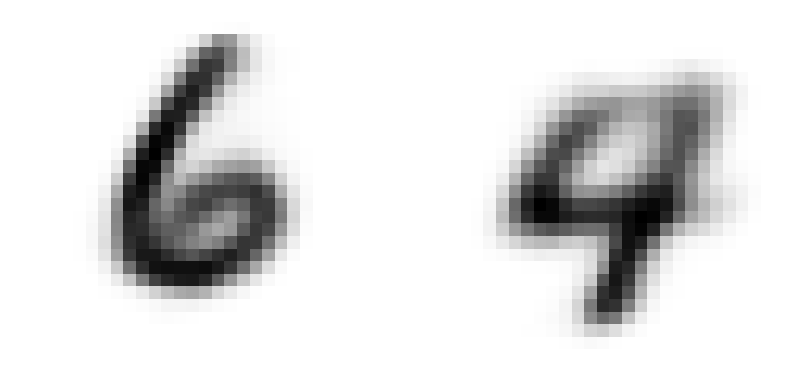

In [401]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

v1 = torch.tensor([-3, 5.0])
v2 = torch.tensor([ 2.5,  5.0])

for i, v in enumerate([v1, v2]):
    img = AE.decode(v.to(device).float()).detach().reshape(28, 28)
    ax[i].imshow(img, cmap = 'gray_r')
    ax[i].axis('off')

What would you say the "average" of these two images is? One way to address this question would to simply average the pixels together, which results in the image on the left below. This image just looks like a 6 and a 4 superimposed on top of each other and doesn't appear to mean much of anything. 

Alternatively, we could average the *codes* together and then decode the result. The code-based method actually gives a reasonable image as the answer: according to the latent-space representation of the data, the "average" of a 6 and a 4 is an 8. 

[Text(0.5, 1.0, 'Decoded average of codes')]

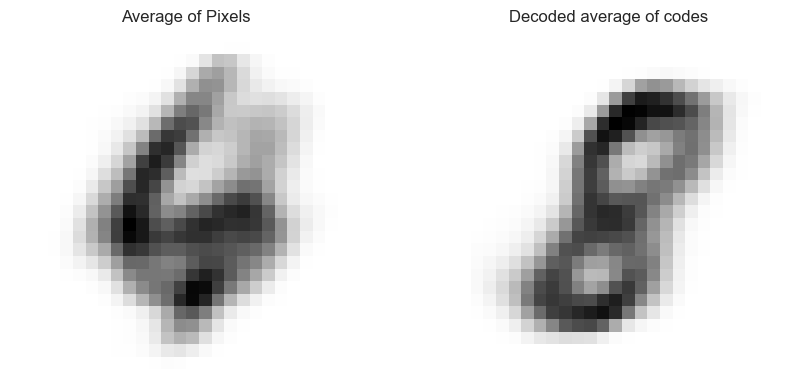

In [403]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = 1/2*(AE.decode(v1.to(device)) + AE.decode(v2.to(device)))
ax[0].imshow(img.detach().reshape(28, 28), cmap='gray_r')
ax[0].axis("off")
ax[0].set(title = "Average of Pixels")

img = AE.decode(1/2*(v1.to(device) + v2.to(device)))
ax[1].imshow(img.detach().reshape(28, 28), cmap='gray_r')
ax[1].axis("off")
ax[1].set(title = "Decoded average of codes")

It can be fun to visualize the entire latent space learned by the model. Here's a function that does this: 

In [404]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('Latent Space')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys")
    plt.gca().axis('off')
    plt.show()

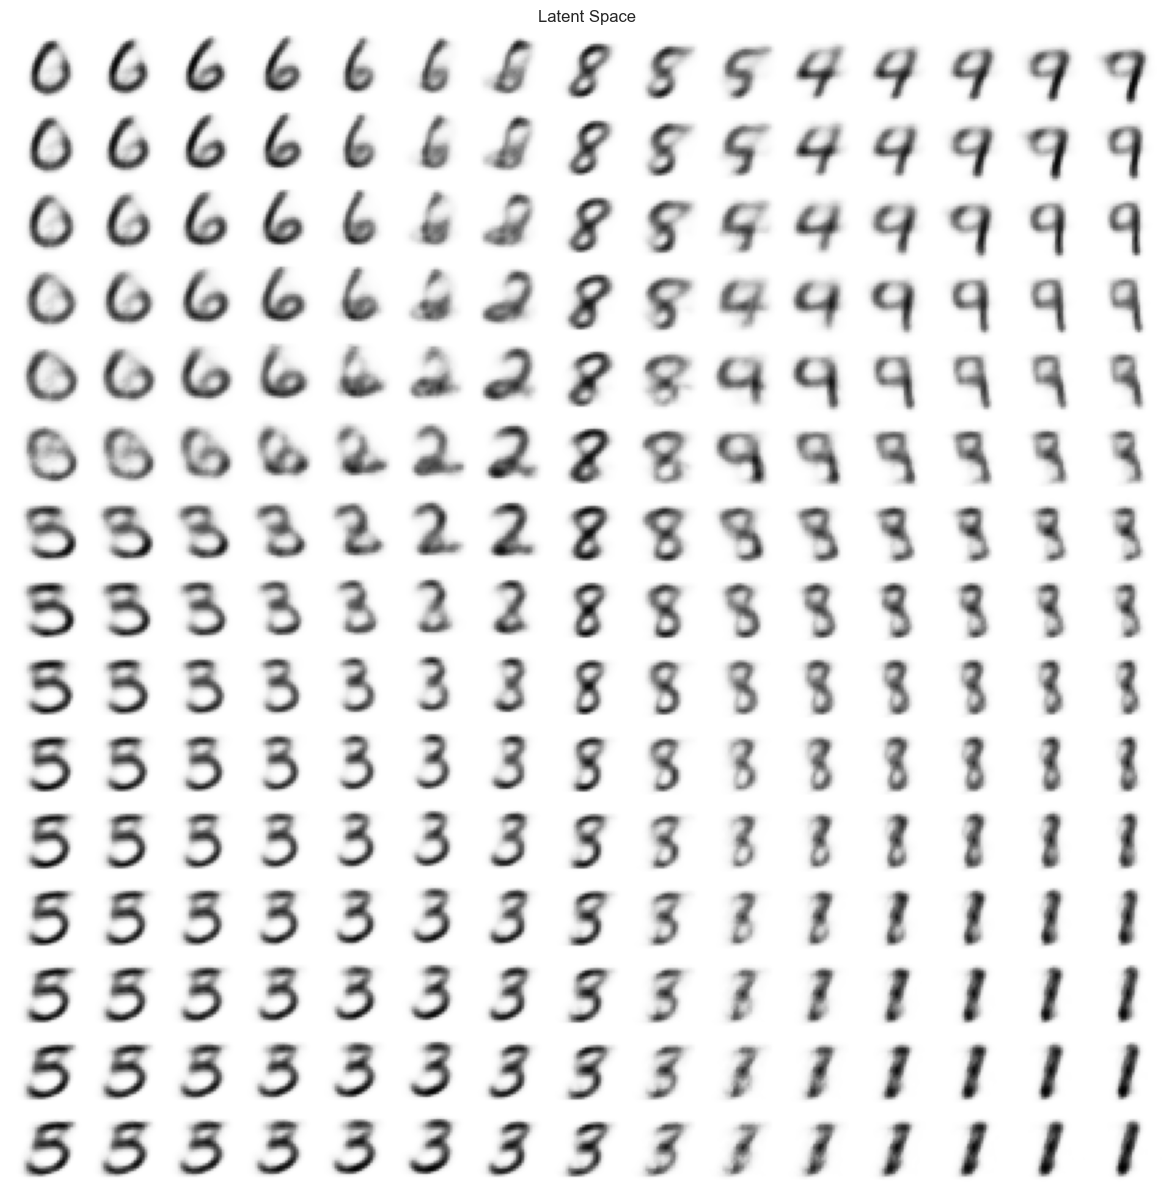

In [407]:
plot_latent_space(AE,  scale = 5, n = 15)

In [363]:
class VariationalAutoEncoder(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VariationalAutoEncoder, self).__init__()

        # encoder: just a simple stack of linear lears
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
            )
        
        # latent mean and variance 
        self.mean_layer   = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        noise = torch.randn_like(logvar).to(device)      
        z = mean + logvar.exp().sqrt()*noise
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

The loss function and training loops are slightly more complicated due to the need to incorporate the distributional representations of the data into the loss function. 

In [364]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [365]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            # print(x.size())
            x = x.to(device)
            x = x.flatten(start_dim=1).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))

In [366]:
VAE = VariationalAutoEncoder().to(device)
optimizer = torch.optim.Adam(VAE.parameters(), lr=1e-3)

In [367]:
train(VAE, optimizer, epochs=20, device=device)

	Epoch 1 	Average Loss:  182.350444947308
	Epoch 2 	Average Loss:  158.6704697281928
	Epoch 3 	Average Loss:  153.547736738966
	Epoch 4 	Average Loss:  150.44187529345785
	Epoch 5 	Average Loss:  148.48527907841193
	Epoch 6 	Average Loss:  147.1077758177692
	Epoch 7 	Average Loss:  145.97775467250105
	Epoch 8 	Average Loss:  145.33086971123748
	Epoch 9 	Average Loss:  144.54358023463584
	Epoch 10 	Average Loss:  143.76906329885747
	Epoch 11 	Average Loss:  143.34565946499373
	Epoch 12 	Average Loss:  142.77528005660477
	Epoch 13 	Average Loss:  142.40163152780676
	Epoch 14 	Average Loss:  141.6837834704977
	Epoch 15 	Average Loss:  141.3765532071682
	Epoch 16 	Average Loss:  140.79681084685413
	Epoch 17 	Average Loss:  140.59439368348288
	Epoch 18 	Average Loss:  140.27084253378027
	Epoch 19 	Average Loss:  139.71046932061248
	Epoch 20 	Average Loss:  139.6006543131782


8362079.193359375

How does the latent space look under the variational autoencoder? 

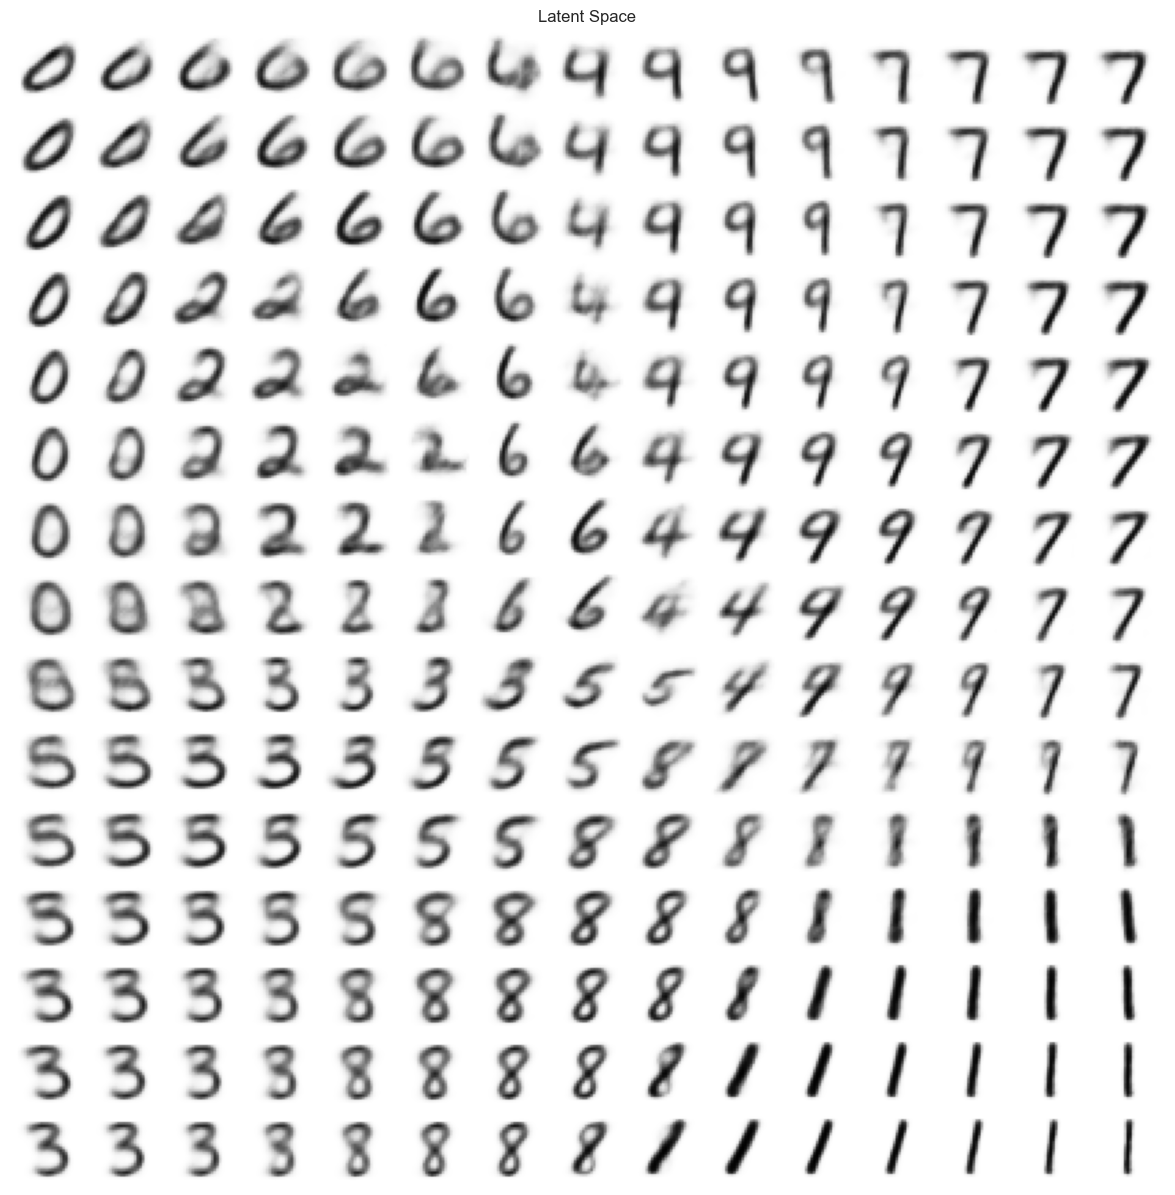

In [374]:
plot_latent_space(VAE, scale = 1.5, n = 15)


This latent space learned by the variational autoencoder contains arguably fewer strange artifacts and nonsensical transitions than the "standard" autoencoder. 